In [1]:
from collections import defaultdict, Counter, namedtuple
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import random
import copy

In [2]:
chroms = [str(x) for x in range(1, 23)]
#chroms = ['18']
ihart_family_sizes = [3, 4, 5, 6]
ihart_phase_dir = '../phased_ihart'
ssc_family_sizes = [3, 4]
ssc_phase_dir = '../phased_ssc'

In [3]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [4]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}

chrom_offsets = [0]
for chrom in chroms:
    chrom_offsets.append(chrom_offsets[-1]+chrom_lengths[chrom])
print(chrom_offsets)

[0, 249250621, 492449994, 690472424, 881626700, 1062541960, 1233657027, 1392795690, 1539159712, 1680373143, 1815907890, 1950914406, 2084766301, 2199936179, 2307285719, 2409817111, 2500171864, 2581367074, 2659444322, 2718573305, 2781598825, 2829728720, 2881033286]


# Filter Families


In [5]:
family_to_individuals = dict()

def load_families(phase_dir, family_sizes):
    family_to_chroms = defaultdict(set)
    
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_to_include = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_to_include))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    return families_to_include
ihart_families = load_families(ihart_phase_dir, ihart_family_sizes)
ssc_families = load_families(ssc_phase_dir, ssc_family_sizes)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 766
Counter({22: 766, 18: 41, 21: 24, 20: 17, 19: 11})
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 233
Counter({22: 233, 10: 92, 12: 36, 17: 33, 15: 32, 20: 18, 21: 16, 16: 14, 14: 10, 11: 8, 9: 8, 13: 7, 19: 6, 18: 5})


In [6]:
ihart_individuals = sorted(sum([family_to_individuals[k] for k in ihart_families], []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
ssc_individuals = sorted(sum([family_to_individuals[k] for k in ssc_families], []))
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])

# Read in deletions


In [7]:
Deletion = namedtuple('Deletion', ['family', 'chrom', 'start_pos', 'end_pos', 'length', 'opt_start_pos', 'opt_end_pos', 'trans', 'notrans', 
                                      'family_size', 'is_mat', 'is_pat', 'state', 'dataset', 'supporting_sites'])



In [8]:
from collections import defaultdict

def read_deletions(chrom, phase_dir, family_sizes, families, dataset):
    deletions = []

    for j in family_sizes:
            
        # load deletions
        family_to_states = defaultdict(list)
        family_to_pos = defaultdict(list)
        family_to_indices = defaultdict(list)
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    start_index, end_index = [int(x) for x in pieces[(4+(j*2)):(6+(j*2))]]
                    assert end_pos >= start_pos
                        
                    # if a segment is never inherited, we don't know if it has a deletion or not
                    if state[0] == 0 and state[1] == 0:
                        pass
                    else:
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                            state[0] = -1
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                            state[1] = -1
                    if state[2] == 0 and state[3] == 0:
                        pass
                    else:
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                            state[2] = -1
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                            state[3] = -1

                    family_to_states[family_key].append(state)
                    family_to_pos[family_key].append((start_pos, end_pos))
                    family_to_indices[family_key].append((start_index, end_index))

        # for each family, detect deletion transmission
        for family_key, states in family_to_states.items():
            states = np.asarray(states)
            assert np.all(states[0, :4] != 0)
            assert np.all(states[-1, :4] != 0)
            positions = np.asarray(family_to_pos[family_key])
            pos_indices = np.asarray(family_to_indices[family_key])
            inds = family_to_individuals[family_key]

            # for each ancestral chromosome
            for anc in range(4):
                is_mat = anc==0 or anc==1
                is_pat = anc==2 or anc==3
                    
                start_indices = np.where((states[:-1, anc] != 0) & (states[1:, anc] == 0))[0]+1
                end_indices = np.where((states[:-1, anc] == 0) & (states[1:, anc] != 0))[0]+1
                for s_ind, e_ind in zip(start_indices, end_indices):
                    
                    # check if parental double deletion
                    if is_mat:
                        is_double = np.all(states[s_ind, :2]==0)
                    else:
                        is_double = np.all(states[s_ind, 2:4]==0)
        
                    # check if recombination event occured and that inheritance state is known
                    has_recomb = False
                    if is_mat:
                        indices = np.arange(4, states.shape[1]-1, 2)
                    else:
                        indices = np.arange(5, states.shape[1]-1, 2)
                        
                    inh_known = np.all(states[s_ind:e_ind, indices] != -1)
                        
                    for i in range(s_ind, e_ind):
                        if np.any(states[i, indices] != states[s_ind, indices]):
                            has_recomb = True
                            
                    # check if in ok region
                    ok_region = np.all(states[s_ind:e_ind, -1] == 0)
                    
                    if ok_region and inh_known and (not has_recomb):
                        start_pos, end_pos = positions[s_ind, 0], positions[e_ind-1, 1]
                        start_pos_index, end_pos_index = pos_indices[s_ind, 0], pos_indices[e_ind-1, 1]
                        
                        # find boundaries of the deletion
                        #print(s_ind, e_ind)
                        opt_start_index = s_ind
                        while states[opt_start_index, anc] != 1 and opt_start_index > 0:
                            opt_start_index -= 1
                        opt_start_pos = positions[opt_start_index+1, 0]
                        
                        opt_end_index = e_ind
                        while(states[opt_end_index, anc]) != 1 and opt_end_index < states.shape[0]-1:
                            opt_end_index += 1
                        opt_end_pos = positions[e_ind-1, 1]
                        
                        assert start_pos <= end_pos
                        assert opt_start_pos <= start_pos
                        assert end_pos <= opt_end_pos
                        
                        state = states[s_ind, :]
                    
                        # children
                        trans, notrans = [], []
                        for k, child in zip(range(2, j), inds[2:]):
                            mom_s, dad_s = state[(2*k):(2*(k+1))]

                            if is_mat:
                                assert mom_s != -1
                                if anc==mom_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)
                            if is_pat:
                                assert dad_s != -1
                                if anc==2+dad_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)

                        if (len(trans) + len(notrans) == j-2) and (len(trans) > 0):
                            deletions.append(Deletion(family_key, chrom, start_pos, end_pos, end_pos-start_pos+1,
                                                      opt_start_pos, opt_end_pos,
                                                              tuple(trans), tuple(notrans), j, is_mat, is_pat,
                                                              tuple(states[s_ind, :]), dataset,
                                                    end_pos_index-start_pos_index+1))
                        
    # sort deletions
    deletions = sorted(deletions, key=lambda x: x.start_pos)
    return deletions



In [9]:
class DeletionCollection:
    def __init__(self, deletion, matches):
        self.deletion = deletion
        self.matches = matches

def create_collections(deletions):
    collections = []
    
    starts = np.array([d.start_pos for d in deletions])
    stops = np.array([d.end_pos for d in deletions])

    ordered_start_indices = np.argsort(starts)
    ordered_starts = starts[ordered_start_indices]
    ordered_stop_indices = np.argsort(stops)
    ordered_stops = stops[ordered_stop_indices]
        
    insert_starts_in_stops = np.searchsorted(ordered_stops, starts)
    insert_stops_in_starts = np.searchsorted(ordered_starts, stops, side='right')
        
    indices = np.ones((len(deletions),), dtype=bool)

    for del_index, main_d in enumerate(deletions):
        indices[:] = True
        indices[ordered_stop_indices[:insert_starts_in_stops[del_index]]] = False
        indices[ordered_start_indices[insert_stops_in_starts[del_index]:]] = False

        collections.append(DeletionCollection(main_d, [deletions[j] for j in np.where(indices)[0]]))
    return collections



In [10]:
def prune_deletions(collections, share_cutoff=0.8):    
    # first, prune deletions that don't overlap with the main deletion by share_cutoff
    for c in collections:
        lengths = np.array([d.length for d in c.matches])
        overlaps1 = np.array([min(d.opt_end_pos, c.deletion.end_pos)-max(d.opt_start_pos, c.deletion.start_pos)+1 for d in c.matches])
        overlaps2 = np.array([min(d.end_pos, c.deletion.opt_end_pos)-max(d.start_pos, c.deletion.opt_start_pos)+1 for d in c.matches])
        c.matches = set([c.matches[j] for j in np.where((overlaps2 >= 0) & (overlaps1 >= share_cutoff*c.deletion.length))[0]])
    return collections

def prune_collections(collections):
        
    deletion_to_index = dict([(x.deletion, i) for i, x in enumerate(collections)])
    
    # now, get rid of collections that are identical to other collections
    for c in collections:
        if c is not None:
            for d in c.matches:
                index = deletion_to_index[d]
                if (c.deletion != d) and (collections[index] is not None) and (c.matches == collections[index].matches):
                    collections[index] = None
    #print('removing %d of %d' % (len([x for x in collections if x is None]), len(collections)))
    collections = [x for x in collections if x is not None]
    return collections





In [11]:
all_collections = []
for chrom in chroms:
    print(chrom, end=' ')
    
    ihart_deletions = read_deletions(chrom, ihart_phase_dir, ihart_family_sizes, ihart_families, 'iHART')
    print('id', end=' ')
    
    ssc_deletions = read_deletions(chrom, ssc_phase_dir, ssc_family_sizes, ssc_families, 'SSC')
    print('sd', end=' ')
    
    deletions = sorted(ihart_deletions + ssc_deletions, key=lambda x: x.start_pos)
    collections = create_collections(deletions)
    print('c', end=' ')
    
    collections = prune_deletions(collections)
    print('p', end=' ')
    
    collections = prune_collections(collections)
    print(len(collections))
    
    all_collections.append(collections)    
    

1 id sd c p 11436
2 id sd c p 11363
3 id sd c p 6926
4 id sd c p 9601
5 id sd c p 7541
6 id sd c p 7829
7 id sd c p 9637
8 id sd c p 8517
9 id sd c p 9148
10 id sd c p 6531
11 id sd c p 7102
12 id sd c p 5181
13 id sd c p 4214
14 id sd c p 10593
15 id sd c p 5438
16 id sd c p 4749
17 id sd c p 4517
18 id sd c p 3226
19 id sd c p 5742
20 id sd c p 2279
21 id sd c p 1916
22 id sd c p 3570


# Modified TDT

In [12]:
def create_contingency(collections, family_sizes, filter_child, verbose=True):
    # chrom, collection, family_size, notrans/trans
    contingency = [np.zeros((len(collections[i]), len(family_sizes), 2)) for i in range(len(chroms))]
    familysize_to_index = dict([(x, i) for i, x in enumerate(family_sizes)])
    for i, chrom in enumerate(chroms):
        if verbose:
            print(chrom, end=' ')
        for j, c in enumerate(collections[i]):
            for k, s in enumerate(family_sizes):
                contingency[i][j, k, 0] = sum([len([x for x in d.notrans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
                contingency[i][j, k, 1] = sum([len([x for x in d.trans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
    return contingency

contingency_both_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and child_id_to_sex[child_id]=='1')
contingency_both_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and child_id_to_sex[child_id]=='1')

contingency_ihart_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and dataset=='iHART' and child_id_to_sex[child_id]=='1')
contingency_ihart_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and dataset=='iHART' and child_id_to_sex[child_id]=='1')

contingency_ssc_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and dataset=='SSC' and child_id_to_sex[child_id]=='1')
contingency_ssc_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and dataset=='SSC' and child_id_to_sex[child_id]=='1')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [13]:
import bayesian_transmission_rate as btr
import importlib
importlib.reload(btr)

transrates_both_aff = [btr.calculate_transmission_rates(contingency_both_aff[i], ihart_family_sizes) for i in range(len(chroms))]
transrates_both_unaff = [btr.calculate_transmission_rates(contingency_both_unaff[i], ihart_family_sizes) for i in range(len(chroms))]

transrates_ihart_aff = [btr.calculate_transmission_rates(contingency_ihart_aff[i], ihart_family_sizes) for i in range(len(chroms))]
transrates_ihart_unaff = [btr.calculate_transmission_rates(contingency_ihart_unaff[i], ihart_family_sizes) for i in range(len(chroms))]
              
transrates_ssc_aff = [btr.calculate_transmission_rates(contingency_ssc_aff[i], ihart_family_sizes) for i in range(len(chroms))]
transrates_ssc_unaff = [btr.calculate_transmission_rates(contingency_ssc_unaff[i], ihart_family_sizes) for i in range(len(chroms))]
            

In [14]:
ind_indices = [np.ones((len(all_collections[i]),), dtype=bool) for i in range(len(chroms))]
for i, chrom in enumerate(chroms):
    used_deletions = set()
    for j in np.flip(np.argsort([sum([len(d.trans)+len(d.notrans) for d in c.matches]) for c in all_collections[i]])):
        c = all_collections[i][j]
        ind_indices[i][j] = np.all([x not in used_deletions for x in c.matches])
        if ind_indices[i][j]:
            used_deletions.update(c.matches)
    print(np.sum(ind_indices[i]))

2032
2037
1719
1826
1532
1599
1679
1493
1235
1254
1326
1255
875
984
876
1005
864
711
845
565
419
488


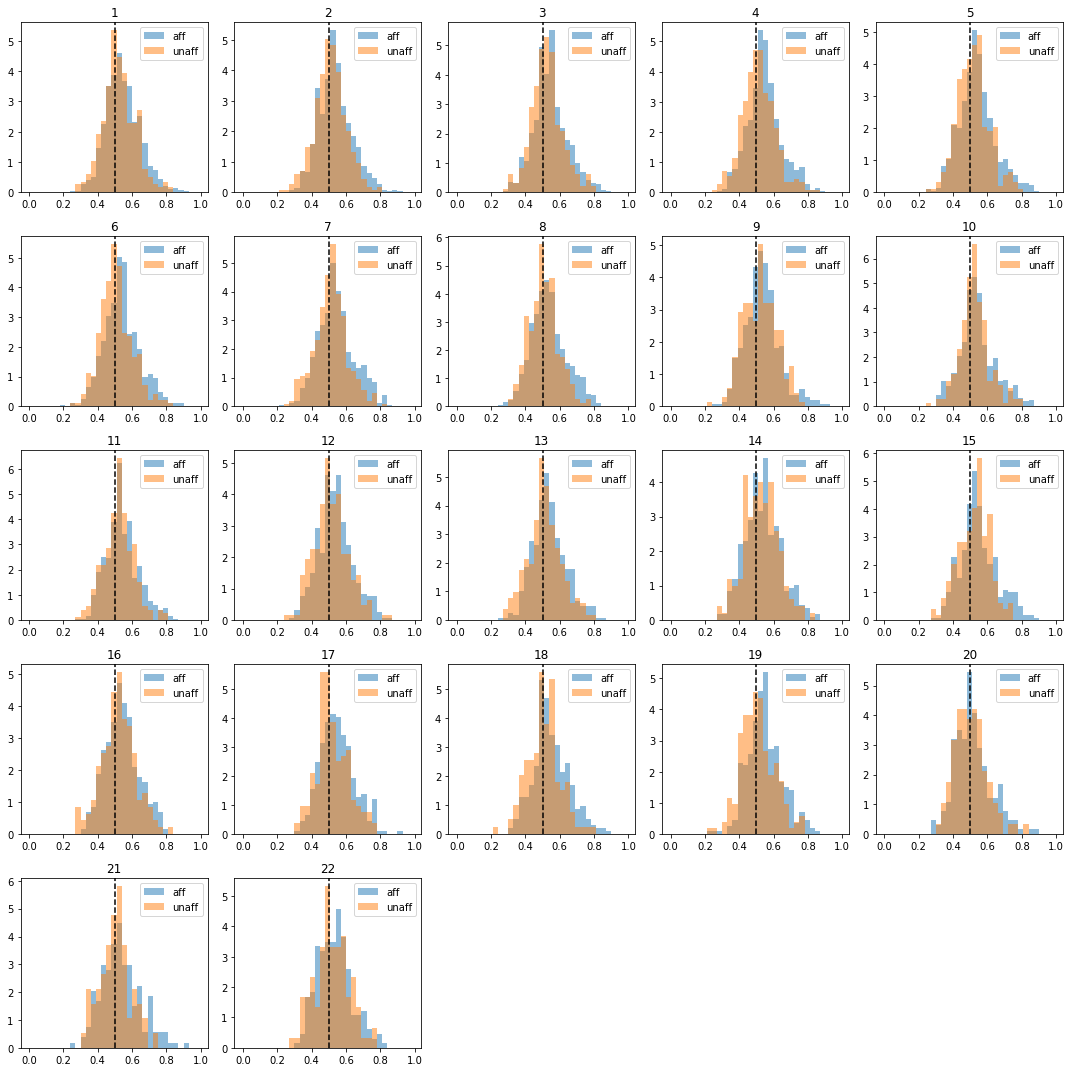

In [15]:
plt.figure(figsize=(15, 15))

for i, chrom in enumerate(chroms):
    
    deletion_to_index = dict([(x.deletion, j) for j, x in enumerate(all_collections[i])])

    plt.subplot(5, 5, i+1)
    plt.hist(transrates_ihart_aff[i][ind_indices[i]], bins=np.arange(0, 1, 0.03), alpha=0.5, label='aff', density=True)
    plt.hist(transrates_ihart_unaff[i][ind_indices[i]], bins=np.arange(0, 1, 0.03), alpha=0.5, label='unaff', density=True)

    plt.axvline(0.5, color='black', linestyle='--')
    plt.legend()
    plt.title(chrom)
    
plt.tight_layout()
plt.show()

In [16]:
print(np.hstack(ind_indices).shape)
print(np.hstack(transrates_ihart_aff).shape)

(147056,)
(147056,)


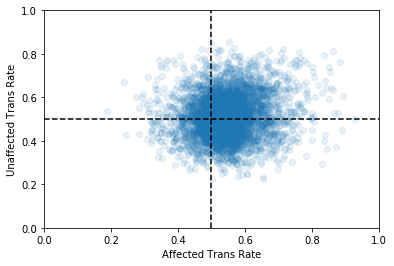

In [17]:
plt.scatter(np.hstack(transrates_ihart_aff)[np.hstack(ind_indices)], np.hstack(transrates_ihart_unaff)[np.hstack(ind_indices)], alpha=0.1)
plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [18]:
importlib.reload(btr)

#ihart
posteriors_ihart_aff = [btr.calculate_posteriors(contingency_ihart_aff[i], ihart_family_sizes) for i in range(len(chroms))]
posteriors_ihart_unaff = [btr.calculate_posteriors(contingency_ihart_unaff[i], ihart_family_sizes) for i in range(len(chroms))]

#ssc
posteriors_ssc_aff = [btr.calculate_posteriors(contingency_ssc_aff[i], ihart_family_sizes) for i in range(len(chroms))]
posteriors_ssc_unaff = [btr.calculate_posteriors(contingency_ssc_unaff[i], ihart_family_sizes) for i in range(len(chroms))]

#both
posteriors_both_aff = [btr.calculate_posteriors(contingency_both_aff[i], ihart_family_sizes) for i in range(len(chroms))]
posteriors_both_unaff = [btr.calculate_posteriors(contingency_both_unaff[i], ihart_family_sizes) for i in range(len(chroms))]


In [19]:
importlib.reload(btr)

overlap_ihart = [btr.calculate_posterior_overlap(posteriors_ihart_aff[i], posteriors_ihart_unaff[i]) for i in range(len(chroms))]
print(np.min([np.min(overlap_ihart[i]) for i in range(len(chroms))]))

overlap_ssc = [btr.calculate_posterior_overlap(posteriors_ssc_aff[i], posteriors_ssc_unaff[i]) for i in range(len(chroms))]
print(np.min([np.min(overlap_ssc[i]) for i in range(len(chroms))]))

overlap_both = [btr.calculate_posterior_overlap(posteriors_both_aff[i], posteriors_both_unaff[i]) for i in range(len(chroms))]
print(np.min([np.min(overlap_both[i]) for i in range(len(chroms))]))



0.007352317485689404
0.02721035250227115
0.014138506766110245


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

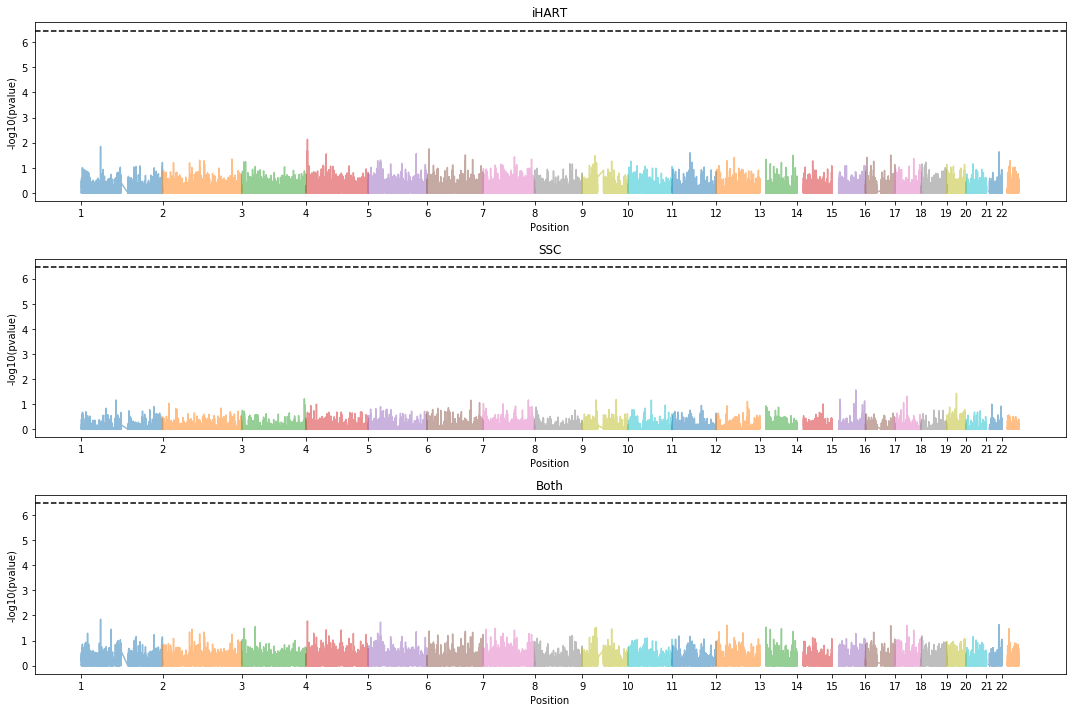

In [20]:
plt.figure(figsize=(15, 10))
 
cutoff = -np.log10(0.05/sum([len(contingency_both_aff[i]) for i in range(len(chroms))]))
#cutoff = -np.log10(0.05/len(all_collections))

plt.subplot(3, 1, 1)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.xticks(chrom_offsets[:-1], chroms)
plt.title('iHART')

plt.subplot(3, 1, 2)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.xticks(chrom_offsets[:-1], chroms)
plt.title('SSC')

plt.subplot(3, 1, 3)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.xticks(chrom_offsets[:-1], chroms)
plt.title('Both')

for i, chrom in enumerate(chroms):
    positions = chrom_offsets[i] + np.array([c.deletion.start_pos for c in all_collections[i]])
    plt.subplot(3, 1, 1)
    plt.plot(positions, -np.log10(overlap_ihart[i]),label='iHART', alpha=0.5)
    plt.subplot(3, 1, 2)
    plt.plot(positions, -np.log10(overlap_ssc[i]),label='SSC', alpha=0.5)
    plt.subplot(3, 1, 3)
    plt.plot(positions, -np.log10(overlap_both[i]),label='Both', alpha=0.5)

plt.tight_layout()
plt.show()

In [21]:
#ihart
posterior_pvalues_ihart_aff = [btr.calculate_posterior_pvalue(posteriors_ihart_aff[i]) for i in range(len(chroms))]
posterior_pvalues_ihart_unaff =  [btr.calculate_posterior_pvalue(posteriors_ihart_unaff[i]) for i in range(len(chroms))]

#ssc
posterior_pvalues_ssc_aff =  [btr.calculate_posterior_pvalue(posteriors_ssc_aff[i]) for i in range(len(chroms))]
posterior_pvalues_ssc_unaff =  [btr.calculate_posterior_pvalue(posteriors_ssc_unaff[i]) for i in range(len(chroms))]

#both
posterior_pvalues_both_aff =  [btr.calculate_posterior_pvalue(posteriors_both_aff[i]) for i in range(len(chroms))]
posterior_pvalues_both_unaff =  [btr.calculate_posterior_pvalue(posteriors_both_unaff[i]) for i in range(len(chroms))]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

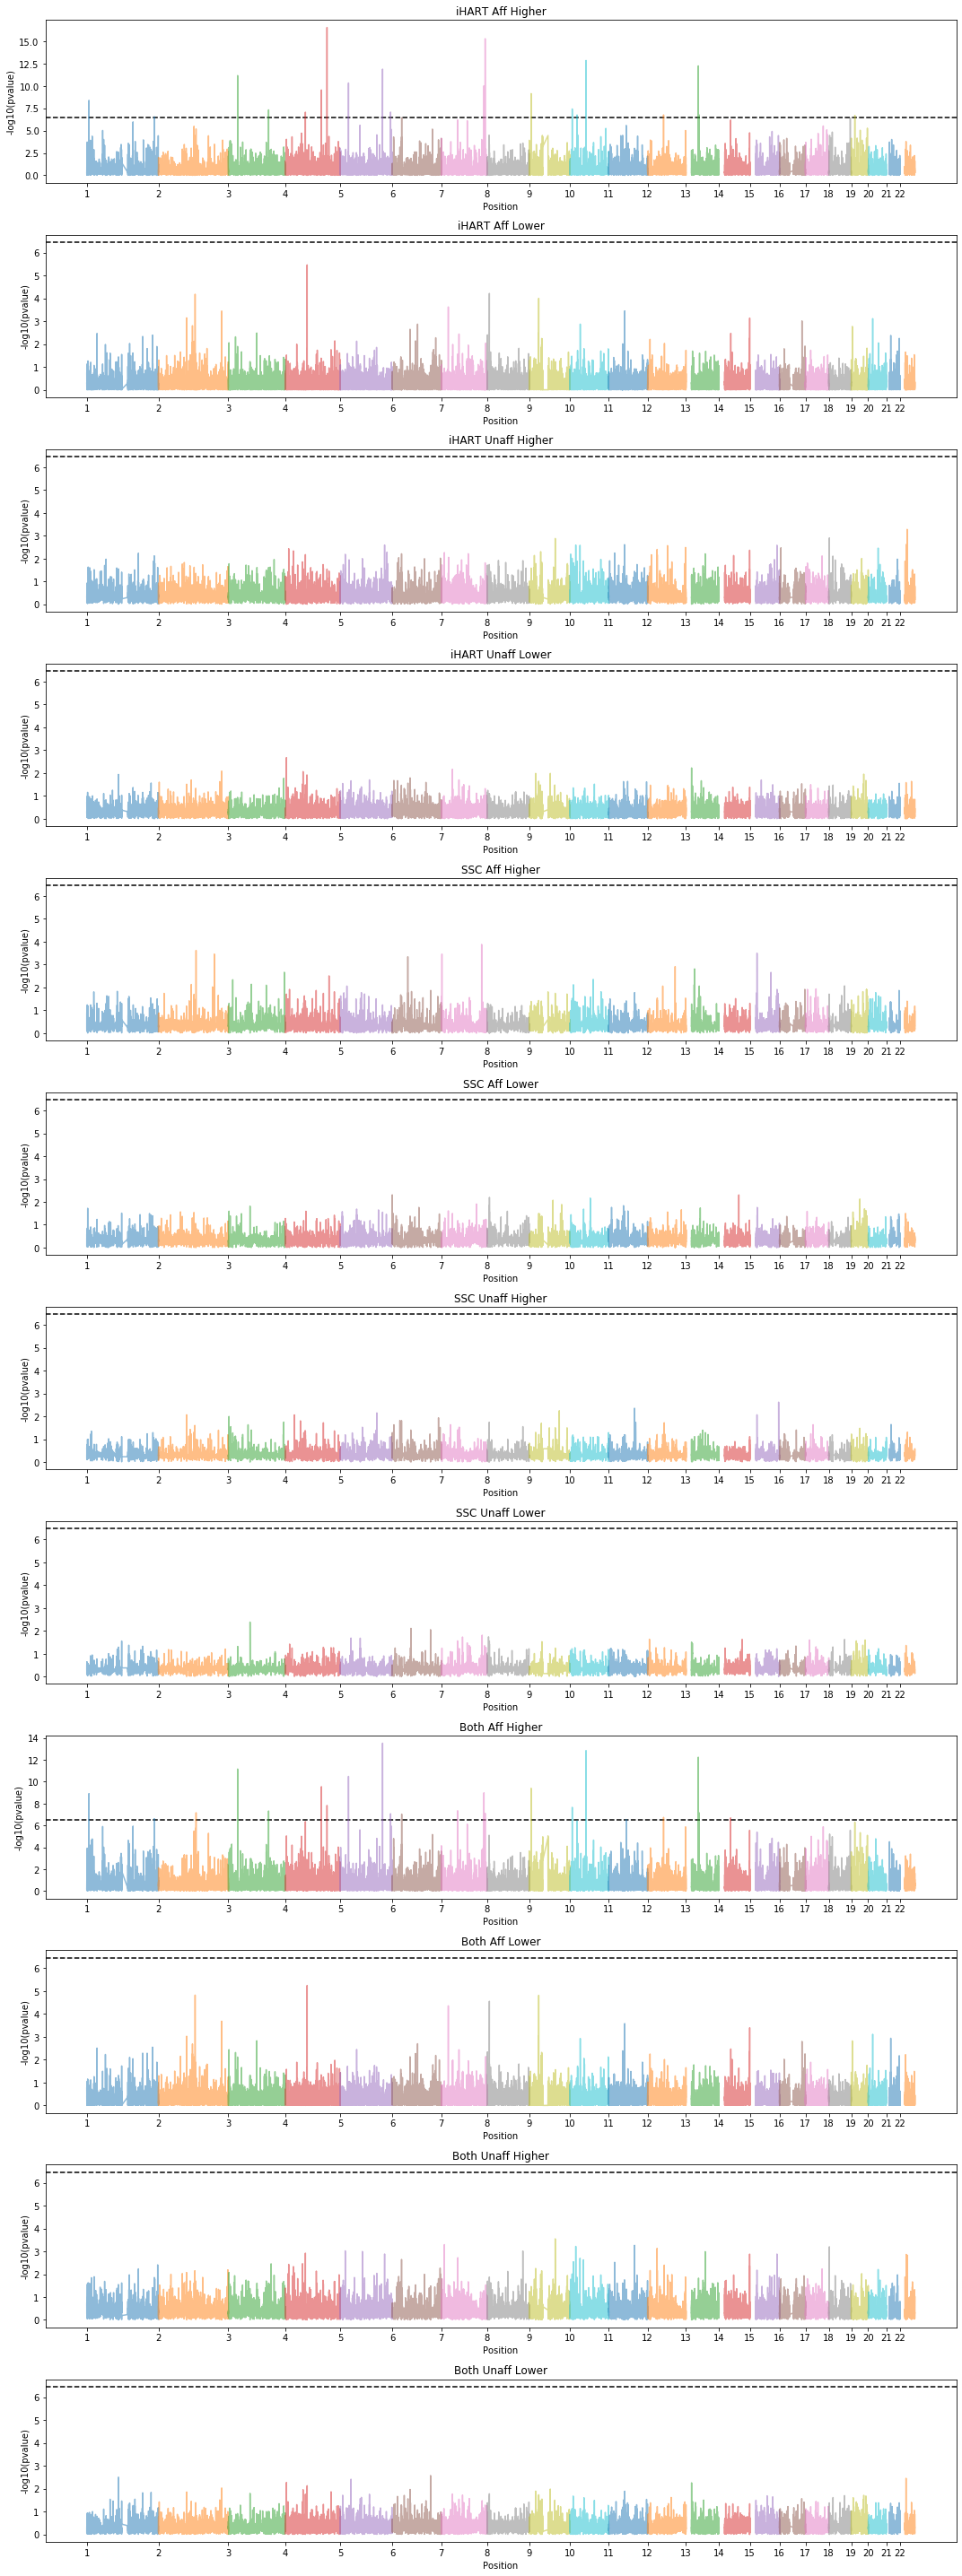

In [22]:
plt.figure(figsize=(15, 40))
 
cutoff = -np.log10(0.05/sum([len(contingency_both_aff[i]) for i in range(len(chroms))]))
#cutoff = -np.log10(0.05/len(all_collections))

titles = ['iHART Aff Higher', 'iHART Aff Lower', 'iHART Unaff Higher', 'iHART Unaff Lower',
         'SSC Aff Higher', 'SSC Aff Lower', 'SSC Unaff Higher', 'SSC Unaff Lower',
         'Both Aff Higher', 'Both Aff Lower', 'Both Unaff Higher', 'Both Unaff Lower']

for i, title in enumerate(titles):
    plt.subplot(12, 1, i+1)
    plt.axhline(cutoff, linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.xticks(chrom_offsets[:-1], chroms)
    plt.title(title)

for i, chrom in enumerate(chroms):
    positions = chrom_offsets[i] + np.array([c.deletion.start_pos for c in all_collections[i]])
    plt.subplot(12, 1, 1)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_aff[i][:, 0]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 2)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_aff[i][:, 1]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 3)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_unaff[i][:, 0]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 4)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_unaff[i][:, 1]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 5)
    plt.plot(positions, -np.log10(posterior_pvalues_ssc_aff[i][:, 0]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 6)
    plt.plot(positions, -np.log10(posterior_pvalues_ssc_aff[i][:, 1]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 7)
    plt.plot(positions, -np.log10(posterior_pvalues_ssc_unaff[i][:, 0]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 8)
    plt.plot(positions, -np.log10(posterior_pvalues_ssc_unaff[i][:, 1]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 9)
    plt.plot(positions, -np.log10(posterior_pvalues_both_aff[i][:, 0]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 10)
    plt.plot(positions, -np.log10(posterior_pvalues_both_aff[i][:, 1]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 11)
    plt.plot(positions, -np.log10(posterior_pvalues_both_unaff[i][:, 0]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 12)
    plt.plot(positions, -np.log10(posterior_pvalues_both_unaff[i][:, 1]), label='unaff', alpha=0.5)

plt.tight_layout()
plt.show()

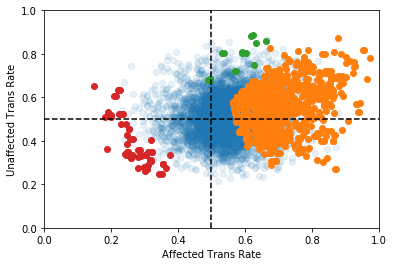

In [23]:
plt.scatter(np.hstack(transrates_both_aff)[np.hstack(ind_indices)], np.hstack(transrates_both_unaff)[np.hstack(ind_indices)], alpha=0.1)

cutoff = 3
indices = -np.log10(np.vstack(posterior_pvalues_both_aff))[:, 0]>=cutoff
plt.scatter(np.hstack(transrates_both_aff)[indices], np.hstack(transrates_both_unaff)[indices])
indices = -np.log10(np.vstack(posterior_pvalues_both_unaff))[:, 0]>=cutoff
plt.scatter(np.hstack(transrates_both_aff)[indices], np.hstack(transrates_both_unaff)[indices])
indices = -np.log10(np.vstack(posterior_pvalues_both_aff))[:, 1]>=cutoff
plt.scatter(np.hstack(transrates_both_aff)[indices], np.hstack(transrates_both_unaff)[indices])
indices = -np.log10(np.vstack(posterior_pvalues_both_unaff))[:, 1]>=cutoff
plt.scatter(np.hstack(transrates_both_aff)[indices], np.hstack(transrates_both_unaff)[indices])

plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [24]:
for i, chrom in enumerate(chroms):
    print(chrom)
    for j in np.where(-np.log10(posterior_pvalues_ihart_aff[i][:, 0]) > cutoff)[0]:
        d = all_collections[i][j].deletion
        print('%s%s:%d-%d %d %d %0.2f' % ('*' if ind_indices[i][j] else '', 
                                       d.chrom, d.opt_start_pos, d.opt_end_pos, d.length, 
                                          j, -np.log10(posterior_pvalues_both_unaff[i][j, 0])))
        print(np.hstack((contingency_ihart_aff[i][j], contingency_ssc_aff[i][j])))
        print(np.hstack((contingency_ihart_unaff[i][j], contingency_ssc_unaff[i][j])))
    
    

1
1:1594837-1595271 435 306 0.92
[[ 0.  1.  0.  0.]
 [17. 78.  2.  8.]
 [13. 27.  0.  0.]
 [ 0.  4.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 4. 2. 6.]
 [1. 4. 0. 0.]
 [0. 0. 0. 0.]]
*1:1594967-1595270 304 308 0.92
[[ 0.  1.  0.  0.]
 [19. 82.  2.  8.]
 [13. 27.  0.  0.]
 [ 0.  4.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 4. 2. 6.]
 [1. 4. 0. 0.]
 [0. 0. 0. 0.]]
1:7558790-7559850 1061 791 1.05
[[ 0.  0.  0.  0.]
 [ 1. 34.  0.  4.]
 [ 4. 11.  0.  0.]
 [ 1.  2.  0.  0.]]
[[0. 0. 0. 0.]
 [1. 0. 0. 3.]
 [0. 3. 0. 0.]
 [0. 2. 0. 0.]]
1:7558790-7560010 1221 792 1.42
[[ 0.  0.  0.  0.]
 [ 1. 31.  0.  4.]
 [ 4. 11.  0.  0.]
 [ 1.  2.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 3.]
 [0. 3. 0. 0.]
 [0. 2. 0. 0.]]
1:7558819-7559646 828 793 1.05
[[ 0.  0.  0.  0.]
 [ 1. 36.  0.  5.]
 [ 4. 11.  0.  0.]
 [ 1.  2.  0.  0.]]
[[0. 0. 0. 0.]
 [1. 0. 0. 3.]
 [0. 3. 0. 0.]
 [0. 2. 0. 0.]]
1:7558819-7558874 56 794 0.71
[[ 0.  0.  0.  0.]
 [ 3. 54.  1.  8.]
 [ 7. 23.  0.  0.]
 [ 3. 10.  0.  0.]]
[[0. 0. 0. 0.]
 [1. 1. 0. 5.]
 [2. 5. 0. 0.

 [0. 2. 0. 0.]]
3:49975722-49976914 1193 1750 0.40
[[ 0.  0.  0.  0.]
 [ 0. 16.  2.  3.]
 [ 9. 19.  0.  0.]
 [ 1.  9.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [5. 4. 0. 0.]
 [0. 2. 0. 0.]]
3:49975739-49976914 1176 1751 0.45
[[ 0.  0.  0.  0.]
 [ 0. 16.  2.  4.]
 [ 9. 19.  0.  0.]
 [ 1.  9.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 5.]
 [5. 4. 0. 0.]
 [0. 2. 0. 0.]]
3:49975932-49976972 1041 1754 0.63
[[ 0.  0.  0.  0.]
 [ 0. 16.  2.  4.]
 [10. 22.  0.  0.]
 [ 1.  9.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 5.]
 [5. 6. 0. 0.]
 [0. 2. 0. 0.]]
3:49975932-49976890 959 1755 0.80
[[ 0.  0.  0.  0.]
 [ 0. 16.  2.  5.]
 [10. 24.  0.  0.]
 [ 1.  9.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 6.]
 [5. 7. 0. 0.]
 [0. 2. 0. 0.]]
3:131989213-131989215 3 4505 1.24
[[  0.   2.   0.   0.]
 [ 76. 184.  26.  74.]
 [ 56. 134.   0.   0.]
 [ 19.  24.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 0.  2. 18. 45.]
 [13. 27.  0.  0.]
 [ 8. 12.  0.  0.]]
3:140138472-140138768 297 4706 1.61
[[ 0.  3.  0.  0.]
 [ 1. 39.  0.  0.]
 [ 2. 22.  0.  

 [ 7.  4.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  1.  2. 20.]
 [17. 10.  0.  0.]
 [ 0.  1.  0.  0.]]
6:5835383-5836094 712 262 0.20
[[ 0.  2.  0.  0.]
 [20. 84.  9. 26.]
 [32. 68.  0.  0.]
 [ 5.  3.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  1.  2. 20.]
 [17. 10.  0.  0.]
 [ 0.  1.  0.  0.]]
6:5835384-5835918 535 264 0.20
[[ 0.  2.  0.  0.]
 [21. 85.  9. 28.]
 [33. 72.  0.  0.]
 [ 5.  3.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  1.  2. 20.]
 [17. 10.  0.  0.]
 [ 0.  1.  0.  0.]]
6:5835589-5835624 36 271 0.16
[[ 0.  2.  0.  0.]
 [26. 99. 10. 32.]
 [47. 99.  0.  0.]
 [ 9.  7.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  1.  5. 21.]
 [19. 14.  0.  0.]
 [ 0.  1.  0.  0.]]
6:5835589-5836184 596 272 0.04
[[  0.   4.   0.   0.]
 [ 56. 174.  22.  51.]
 [ 88. 162.   0.   0.]
 [ 13.  13.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 1.  1. 16. 37.]
 [34. 28.  0.  0.]
 [ 3.  4.  0.  0.]]
6:5835589-5835819 231 274 0.10
[[  0.   4.   0.   0.]
 [ 59. 179.  22.  45.]
 [ 98. 176.   0.   0.]
 [ 13.  14.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 1.

[[0. 0. 0. 0.]
 [0. 1. 1. 2.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]]
8:58126563-58126668 106 5963 0.26
[[ 0.  0.  0.  0.]
 [ 3. 26.  3.  2.]
 [ 2. 13.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 1. 1. 4.]
 [2. 1. 0. 0.]
 [0. 0. 0. 0.]]
8:58126577-58126659 83 5965 0.22
[[ 0.  0.  0.  0.]
 [ 3. 27.  4.  3.]
 [ 3. 14.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 1. 2. 5.]
 [2. 1. 0. 0.]
 [0. 0. 0. 0.]]
*8:115997737-115998353 617 7277 0.08
[[  0.   2.   0.   0.]
 [ 53. 152.   0.   0.]
 [ 59. 117.   0.   0.]
 [ 14.  22.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 4.  3.  0.  0.]
 [17. 20.  0.  0.]
 [ 9.  8.  0.  0.]]
8:124327384-124327670 287 7517 1.78
[[ 0.  2.  0.  0.]
 [22. 57. 15. 31.]
 [13. 43.  0.  0.]
 [ 0.  7.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 2.  0.  3. 19.]
 [ 3. 12.  0.  0.]
 [ 1.  3.  0.  0.]]
8:124327384-124327654 271 7522 2.18
[[ 0.  2.  0.  0.]
 [26. 66. 16. 32.]
 [19. 54.  0.  0.]
 [ 0.  7.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 2.  0.  3. 19.]
 [ 4. 17.  0.  0.]
 [ 1.  3.  0.  0.]]
8:1243274

 [ 2.  3.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 1. 1. 6.]
 [3. 5. 0. 0.]
 [0. 1. 0. 0.]]
11:60997949-60998046 98 4056 0.22
[[  0.   2.   0.   0.]
 [ 52. 146.   6.  23.]
 [ 43.  94.   0.   0.]
 [  3.   6.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 2.  5.  5. 15.]
 [14. 16.  0.  0.]
 [ 2.  1.  0.  0.]]
11:60997994-60998090 97 4057 0.42
[[  0.   0.   0.   0.]
 [ 44. 130.   6.  22.]
 [ 38.  83.   0.   0.]
 [  3.   5.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 1.  5.  3. 14.]
 [13. 15.  0.  0.]
 [ 2.  2.  0.  0.]]
11:60997994-60998036 43 4058 0.18
[[  0.   2.   0.   0.]
 [ 55. 151.   7.  24.]
 [ 47. 100.   0.   0.]
 [  5.   6.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 2.  5.  5. 15.]
 [16. 16.  0.  0.]
 [ 3.  3.  0.  0.]]
11:60997994-60998225 232 4059 0.49
[[ 0.  0.  0.  0.]
 [30. 93.  6. 23.]
 [25. 62.  0.  0.]
 [ 3.  4.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  1.  3. 14.]
 [ 9. 10.  0.  0.]
 [ 1.  2.  0.  0.]]
11:60997994-60998322 329 4061 0.93
[[ 0.  0.  0.  0.]
 [ 7. 53.  6. 23.]
 [10. 32.  0.  0.]
 [ 2.  3.  0.  0.]]
[[ 0. 

 [ 0.  2.  0.  0.]]
15:68426728-68427141 414 3047 0.48
[[  0.   4.   0.   0.]
 [ 56. 156.  22.  52.]
 [ 24.  53.   0.   0.]
 [  0.   6.   0.   0.]]
[[ 0.  0.  0.  1.]
 [ 0.  3. 18. 31.]
 [ 7. 13.  0.  0.]
 [ 0.  2.  0.  0.]]
15:68426026-68427556 829 3048 0.39
[[  0.   4.   0.   0.]
 [ 54. 145.  18.  47.]
 [ 16.  42.   0.   0.]
 [  0.   6.   0.   0.]]
[[ 0.  0.  0.  1.]
 [ 0.  2. 18. 30.]
 [ 6. 11.  0.  0.]
 [ 0.  2.  0.  0.]]
15:68426026-68427196 469 3049 0.48
[[  0.   4.   0.   0.]
 [ 60. 160.  22.  53.]
 [ 23.  52.   0.   0.]
 [  0.   6.   0.   0.]]
[[ 0.  0.  0.  1.]
 [ 0.  3. 18. 31.]
 [ 7. 13.  0.  0.]
 [ 0.  2.  0.  0.]]
15:68426026-68426838 111 3050 0.41
[[  0.   4.   0.   0.]
 [ 55. 154.  21.  52.]
 [ 22.  49.   0.   0.]
 [  1.   6.   0.   0.]]
[[ 0.  0.  0.  1.]
 [ 0.  3. 18. 29.]
 [ 6. 13.  0.  0.]
 [ 1.  2.  0.  0.]]
15:68426741-68427037 297 3051 0.48
[[  0.   4.   0.   0.]
 [ 56. 156.  22.  53.]
 [ 25.  52.   0.   0.]
 [  0.   6.   0.   0.]]
[[ 0.  0.  0.  1.]
 [ 0.  3. 18.

 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [2. 3. 4. 7.]
 [6. 9. 0. 0.]
 [1. 1. 0. 0.]]
19:299742-300342 601 19 0.23
[[ 0.  1.  0.  0.]
 [24. 86.  3. 10.]
 [13. 36.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [2. 3. 4. 7.]
 [6. 9. 0. 0.]
 [1. 1. 0. 0.]]
19:299862-300407 546 21 0.23
[[ 0.  1.  0.  0.]
 [25. 87.  3. 10.]
 [14. 37.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [2. 3. 4. 7.]
 [6. 9. 0. 0.]
 [1. 1. 0. 0.]]
19:3174355-3174986 492 462 0.21
[[  0.   3.   0.   0.]
 [ 36. 106.   6.  18.]
 [ 20.  47.   0.   0.]
 [  5.  11.   0.   0.]]
[[0. 0. 0. 0.]
 [2. 4. 4. 9.]
 [6. 7. 0. 0.]
 [3. 3. 0. 0.]]
19:12694593-12694635 43 1434 0.31
[[ 0.  1.  0.  0.]
 [ 1.  8.  1.  1.]
 [ 3. 23.  0.  0.]
 [ 0.  4.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [2. 4. 0. 0.]
 [0. 0. 0. 0.]]
19:12694608-12694611 4 1435 0.41
[[ 0.  1.  0.  0.]
 [ 1. 19.  2.  4.]
 [ 6. 32.  0.  0.]
 [ 0.  8.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 1. 4.]
 [3. 5. 0. 0.]
 [0. 0. 0. 0.]]
19:12694885-12694947 63 1438 0.53
[[  0.   6.   0.   0.]

In [25]:
print([(x.family, x.family_size) for x in all_collections[20][274].matches])

[('AU1969.AU1969202.AU1969201', 4), ('AU1977.AU1977202.AU1977201', 4), ('AU2082.AU2082202.AU2082201', 4), ('AU0293.AU029301.AU029302', 4), ('AU2756.AU2756202.AU2756201', 4), ('12739.12739.mo.12739.fa', 4), ('AU2001.AU2001202.AU2001201', 4), ('AU1778.AU1778202.AU1778201', 4), ('AU3301.AU3301202.AU3301201', 4), ('AU0579.AU057901.AU057902', 5), ('AU2887.AU2887202.AU2887201', 4), ('12796.12796.mo.12796.fa', 4), ('AU1731.AU1731202.AU1731201', 5), ('AU3301.AU3301202.AU3301201', 4), ('AU0836.AU083601.AU083602', 5), ('AU1371.AU1371202.AU1371201', 4), ('AU1824.AU1824202.AU1824201', 4), ('AU0835.AU083501.AU083502', 5), ('AU2001.AU2001202.AU2001201', 4), ('AU2001.AU2001202.AU2001201', 4), ('AU1401.AU1401202.AU1401201', 4), ('AU1243.AU1243202.AU1243201', 4), ('AU1568.AU1568202.AU1568201', 5), ('AU1796.AU1796202.AU1796201', 5), ('AU3369.AU3369202.AU3369201', 4), ('AU1977.AU1977202.AU1977201', 4), ('11285.11285.mo.11285.fa', 4), ('AU3295.AU3295202.AU3295201', 3), ('AU1842.AU1842202.AU1842201', 5), (

In [26]:
print([[(child_id_to_sex[y], y in x.trans) for y in family_to_individuals[x.family][2:]] for x in all_collections[20][274].matches])





[[('2', True), ('1', False)], [('2', True), ('2', False)], [('1', False), ('1', True)], [('1', True), ('1', True)], [('1', False), ('1', True)], [('1', False), ('1', True)], [('1', True), ('1', True)], [('1', True), ('1', True)], [('1', True), ('1', False)], [('1', False), ('1', True), ('1', False)], [('1', True), ('1', True)], [('2', True), ('1', False)], [('1', True), ('1', True), ('1', False)], [('1', False), ('1', True)], [('1', True), ('1', True), ('1', True)], [('1', True), ('1', True)], [('1', False), ('1', True)], [('1', True), ('1', True), ('1', False)], [('1', False), ('1', True)], [('1', True), ('1', False)], [('1', True), ('1', False)], [('1', True), ('1', False)], [('1', True), ('1', True), ('1', True)], [('2', True), ('1', True), ('2', True)], [('1', True), ('1', False)], [('2', False), ('2', True)], [('1', True), ('1', True)], [('1', True)], [('2', True), ('1', True), ('2', True)], [('1', True), ('2', True)], [('1', False), ('1', True)], [('1', False), ('1', False), ('1'

# Check sex-bias

In [27]:
contingency_ihart_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_sex[child_id]=='1' and dataset == 'iHART')
contingency_ihart_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_sex[child_id]=='2' and dataset == 'iHART')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [28]:
transrates_ihart_m = [btr.calculate_transmission_rates(contingency_ihart_m[i], ihart_family_sizes) for i in range(len(chroms))]
transrates_ihart_f = [btr.calculate_transmission_rates(contingency_ihart_f[i], ihart_family_sizes) for i in range(len(chroms))]
    

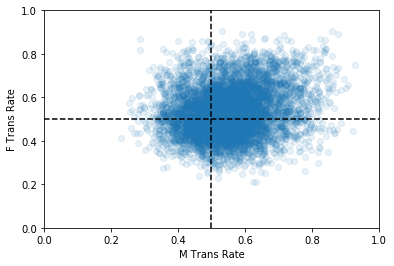

In [29]:
plt.scatter(np.hstack(transrates_ihart_m)[np.hstack(ind_indices)], np.hstack(transrates_ihart_f)[np.hstack(ind_indices)], alpha=0.1)

plt.xlabel('M Trans Rate')
plt.ylabel('F Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [30]:
posteriors_ihart_m = [btr.calculate_posteriors(contingency_ihart_m[i], ihart_family_sizes) for i in range(len(chroms))]
posteriors_ihart_f = [btr.calculate_posteriors(contingency_ihart_f[i], ihart_family_sizes) for i in range(len(chroms))]


In [31]:
overlap_ihart_mf = [btr.calculate_posterior_overlap(posteriors_ihart_m[i], posteriors_ihart_f[i]) for i in range(len(chroms))]
posterior_pvalues_ihart_m = [btr.calculate_posterior_pvalue(posteriors_ihart_m[i]) for i in range(len(chroms))]
posterior_pvalues_ihart_f =  [btr.calculate_posterior_pvalue(posteriors_ihart_f[i]) for i in range(len(chroms))]



//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

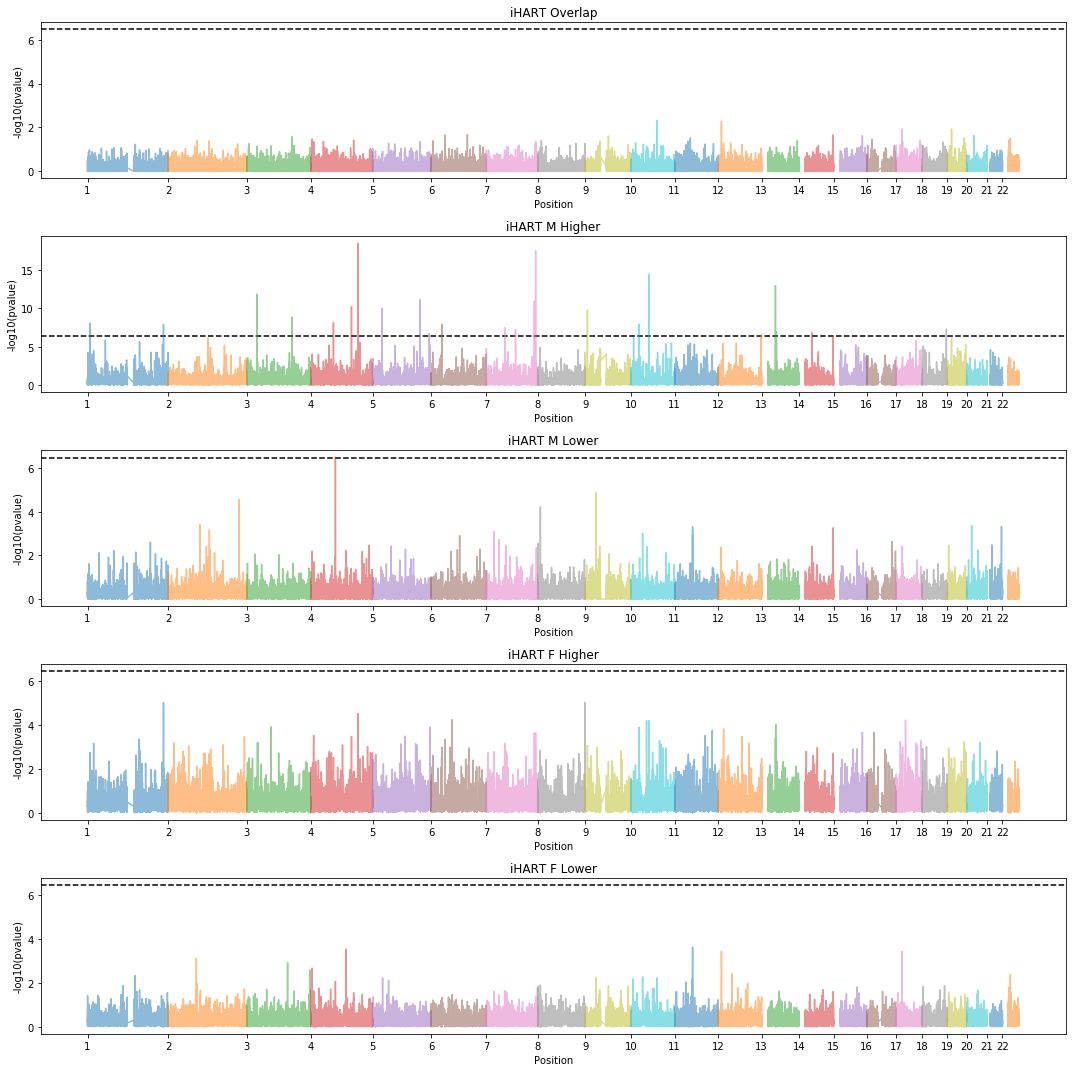

In [32]:
plt.figure(figsize=(15, 15))
 
cutoff = -np.log10(0.05/sum([len(contingency_both_aff[i]) for i in range(len(chroms))]))
#cutoff = -np.log10(0.05/len(all_collections))

titles = ['iHART Overlap', 'iHART M Higher', 'iHART M Lower', 'iHART F Higher', 'iHART F Lower']

for i, title in enumerate(titles):
    plt.subplot(5, 1, i+1)
    plt.axhline(cutoff, linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.xticks(chrom_offsets[:-1], chroms)
    plt.title(title)

for i, chrom in enumerate(chroms):
    positions = chrom_offsets[i] + np.array([c.deletion.start_pos for c in all_collections[i]])
    plt.subplot(5, 1, 1)
    plt.plot(positions, -np.log10(overlap_ihart_mf[i]), alpha=0.5)
    plt.subplot(5, 1, 2)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_m[i][:, 0]), alpha=0.5)
    plt.subplot(5, 1, 3)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_m[i][:, 1]), alpha=0.5)
    plt.subplot(5, 1, 4)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_f[i][:, 0]), alpha=0.5)
    plt.subplot(5, 1, 5)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_f[i][:, 1]), alpha=0.5)
    
plt.tight_layout()
plt.show()

In [33]:
for i, chrom in enumerate(chroms):
    print(chrom)
    for j in np.where(-np.log10(posterior_pvalues_ihart_aff[i][:, 0]) > cutoff)[0]:
        d = all_collections[i][j].deletion
        print('%s%s:%d-%d %d %d %0.2f' % ('*' if ind_indices[i][j] else '', 
                                       d.chrom, d.opt_start_pos, d.opt_end_pos, d.length, 
                                          j, -np.log10(posterior_pvalues_both_unaff[i][j, 0])))
        print(np.hstack((contingency_ihart_aff[i][j], contingency_ssc_aff[i][j])))
        print(np.hstack((contingency_ihart_unaff[i][j], contingency_ssc_unaff[i][j])))
    
        print(posterior_pvalues_ihart_m[i][j, :])

1
1:7558819-7558874 56 794 0.71
[[ 0.  0.  0.  0.]
 [ 3. 54.  1.  8.]
 [ 7. 23.  0.  0.]
 [ 3. 10.  0.  0.]]
[[0. 0. 0. 0.]
 [1. 1. 0. 5.]
 [2. 5. 0. 0.]
 [2. 3. 0. 0.]]
[5.18206682e-07 9.99999513e-01]
*1:7558820-7558835 16 797 0.93
[[ 0.  0.  0.  0.]
 [ 3. 57.  1.  8.]
 [ 7. 30.  0.  0.]
 [ 3. 10.  0.  0.]]
[[0. 0. 0. 0.]
 [1. 1. 0. 5.]
 [2. 7. 0. 0.]
 [2. 3. 0. 0.]]
[8.48551617e-09 9.99999992e-01]
1:7558790-7558842 23 798 0.82
[[ 0.  0.  0.  0.]
 [ 3. 55.  1.  8.]
 [ 7. 25.  0.  0.]
 [ 3. 10.  0.  0.]]
[[0. 0. 0. 0.]
 [1. 1. 0. 5.]
 [2. 6. 0. 0.]
 [2. 3. 0. 0.]]
[1.35315887e-07 9.99999873e-01]
1:7558820-7558849 30 799 0.82
[[ 0.  0.  0.  0.]
 [ 3. 54.  1.  8.]
 [ 7. 25.  0.  0.]
 [ 3. 10.  0.  0.]]
[[0. 0. 0. 0.]
 [1. 1. 0. 5.]
 [2. 6. 0. 0.]
 [2. 3. 0. 0.]]
[1.72202504e-07 9.99999839e-01]
1:234973851-234973979 129 10496 1.86
[[ 0.  1.  0.  0.]
 [24. 99.  3.  5.]
 [30. 83.  0.  0.]
 [ 2.  7.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  4.  1.  3.]
 [ 6. 17.  0.  0.]
 [ 0.  3.  0.  0.]]
[1.231